# Flow training and visualization
In this notebook, we train normalizing flows to fit predefined prior distributions, testing their expressivity. The plots are generated to visualize the learned distributions for given layers $K$, and the training loss is plotted to compare the expressivity of different flows.

In [1]:
%load_ext autoreload
%autoreload 2

# Import required packages
import torch
import numpy as np
import normflow as nf

from matplotlib import pyplot as plt
from tqdm import tqdm

print("PyTorch version: %s" % torch.__version__)
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Using device: %s" % dev)

PyTorch version: 1.4.0
Using device: cuda


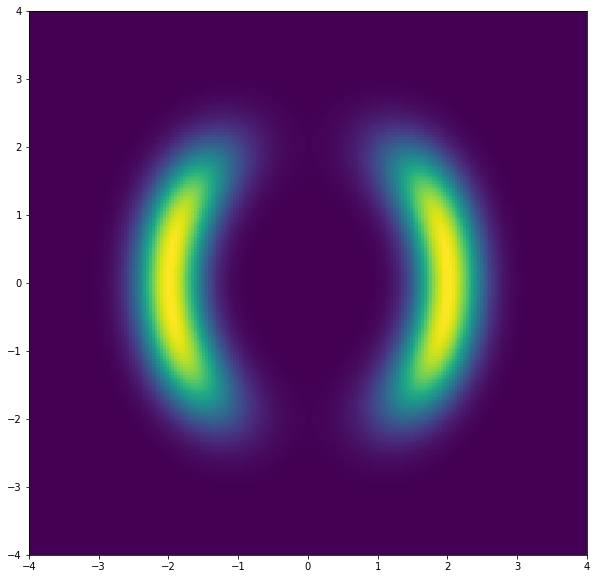

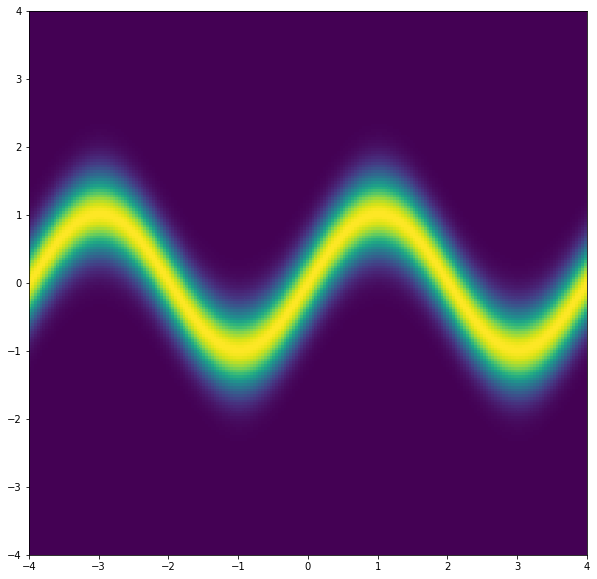

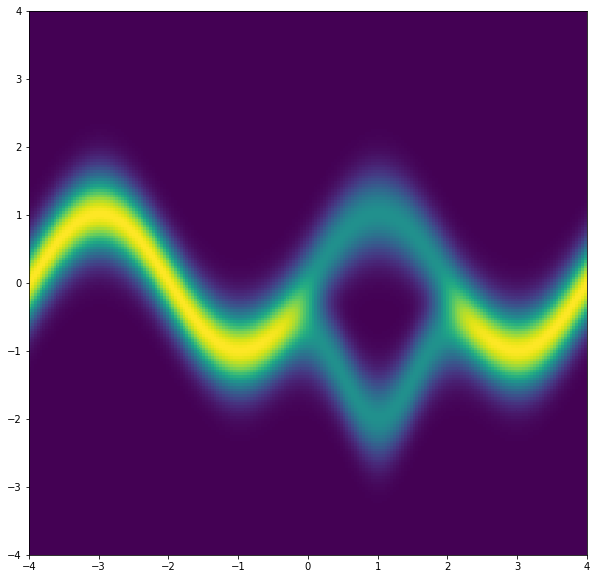

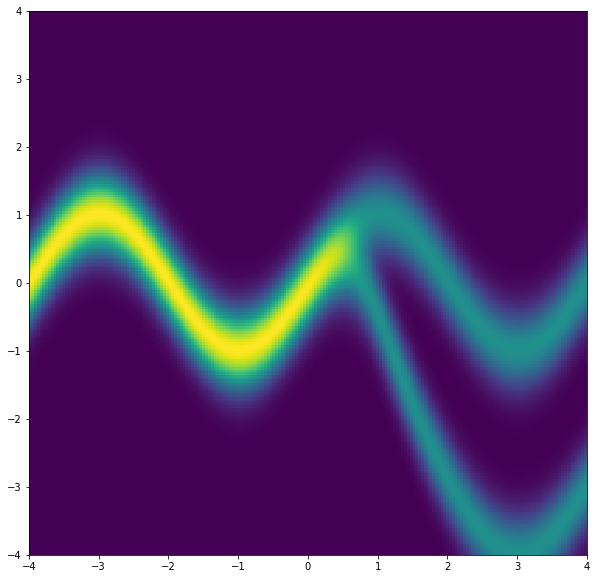

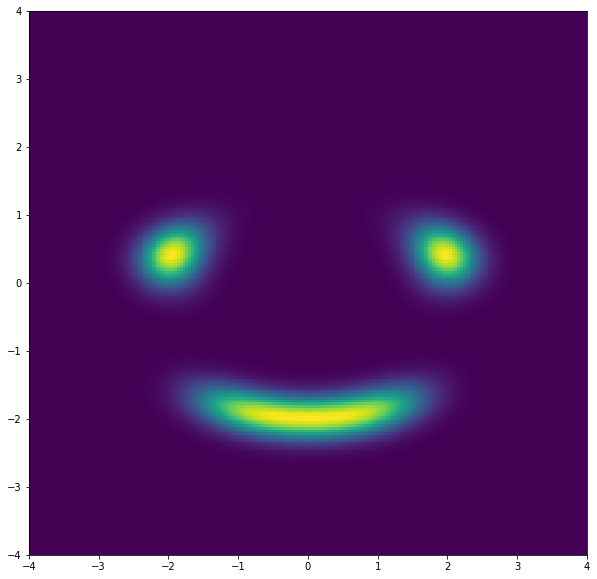

In [2]:
priors = []
priors.append(nf.distributions.TwoModes(2.0, 0.2))
priors.append(nf.distributions.Sinusoidal(0.4, 4))
priors.append(nf.distributions.Sinusoidal_gap(0.4, 4))
priors.append(nf.distributions.Sinusoidal_split(0.4, 4))
priors.append(nf.distributions.Smiley(0.15))


# Plot prior distributions
grid_size = 200
grid_length = 4.0
grid_shape = ([-grid_length, grid_length], [-grid_length, grid_length])

space_mesh = torch.linspace(-grid_length, grid_length, grid_size)
xx, yy = torch.meshgrid(space_mesh, space_mesh)
z = torch.cat([xx.unsqueeze(2), yy.unsqueeze(2)], 2)

K_arr = [2, 8, 32]
max_iter = 30000
batch_size = 512
num_samples = 256
save_iter = 1000

for k in range(5):
    log_prob = priors[k].log_prob(z)
    prob = torch.exp(log_prob)

    plt.figure(figsize=(10, 10))
    plt.pcolormesh(xx, yy, prob)
    plt.show()

K = 2


100%|██████████| 30000/30000 [02:14<00:00, 222.81it/s]


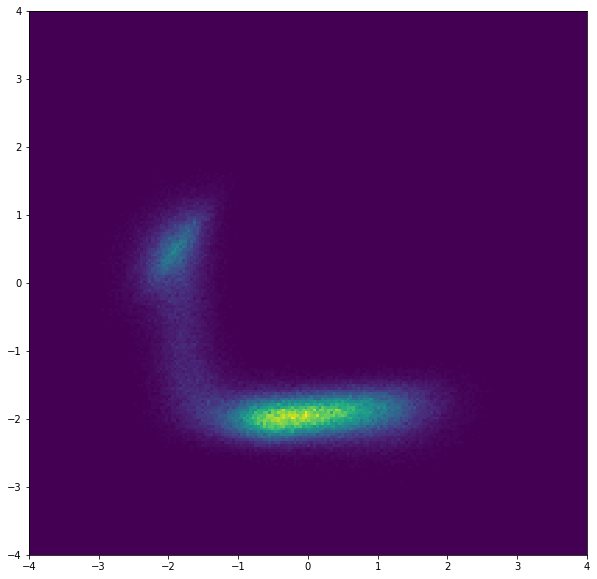

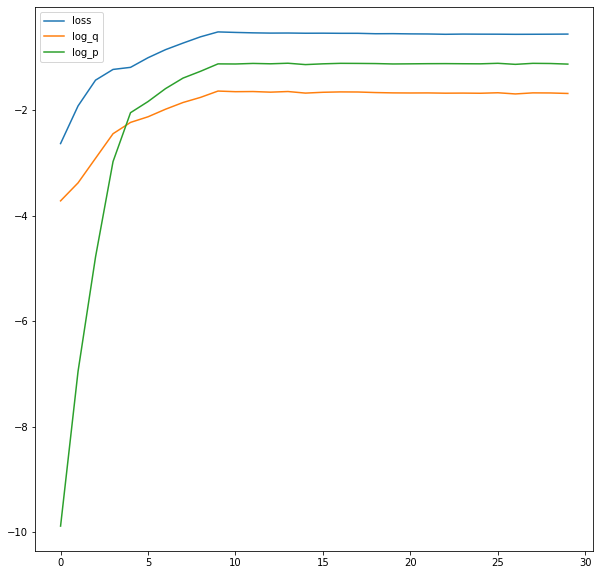

  0%|          | 8/30000 [00:00<06:25, 77.76it/s]

K = 8


100%|██████████| 30000/30000 [06:15<00:00, 79.98it/s]


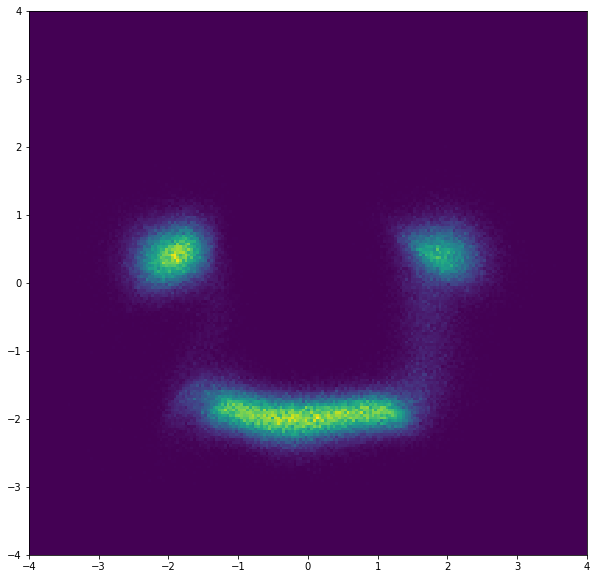

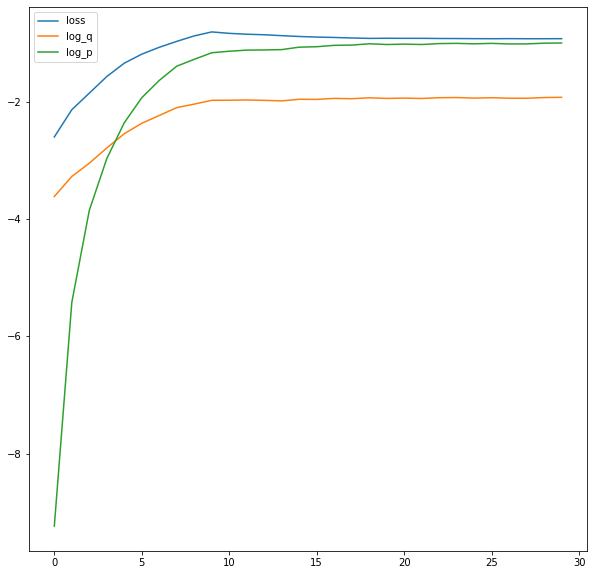

  0%|          | 2/30000 [00:00<26:00, 19.23it/s]

K = 32


100%|██████████| 30000/30000 [22:46<00:00, 21.96it/s]


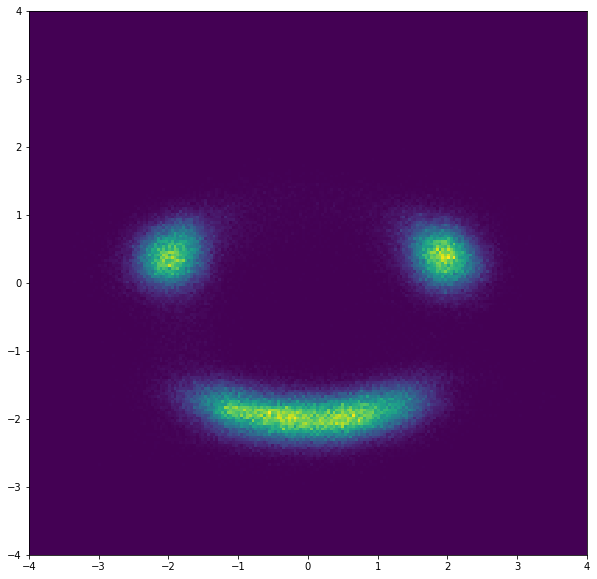

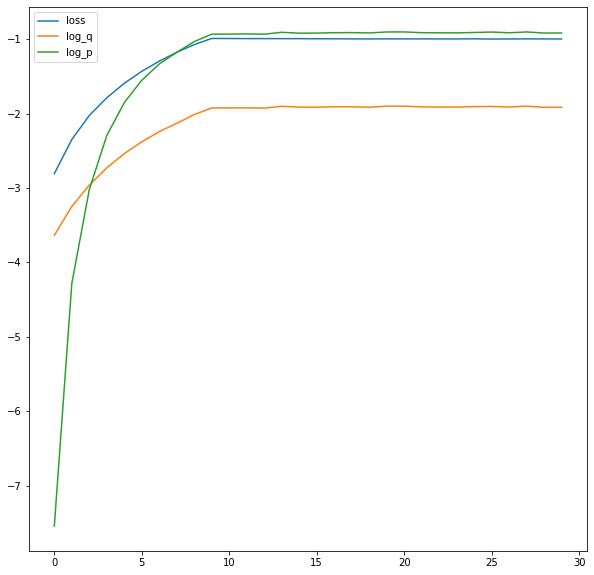

In [4]:
# Planar flows
for K in K_arr:
    
    print("K = {}".format(K))
    for k in range(4,5):
        if k == 0 or k == 4:
            anneal_iter = 10000
        else: # turn annealing off when fitting to sinusoidal distributions
            anneal_iter = 1
        
        flows = []
        for i in range(K):
            flows += [nf.flows.Planar((2,))]

        q0 = nf.distributions.ConstDiagGaussian(np.zeros(2), 2.0)
        nfm = nf.NormalizingFlow(prior=priors[k], q0=q0, flows=flows)
        nfm.to(dev) # Move model on GPU if available
    
        # Train model
        loss_hist = np.array([])
        log_q_hist = np.array([])
        log_p_hist = np.array([])
        x = torch.zeros(batch_size, device=dev)

        optimizer = torch.optim.Adam(nfm.parameters(), lr=1e-3, weight_decay=1e-3)
        for it in tqdm(range(max_iter)):
            optimizer.zero_grad()
            _, log_q, log_p = nfm(x, num_samples)
            mean_log_q = torch.mean(log_q)
            mean_log_p = torch.mean(log_p)
            loss = mean_log_q - np.min([1.0, 0.01 + it / anneal_iter]) * mean_log_p
            loss.backward()
            optimizer.step()
            
            if (it + 1) % save_iter == 0:
                loss_hist = np.append(loss_hist, loss.cpu().data.numpy())
                log_q_hist = np.append(log_q_hist, mean_log_q.cpu().data.numpy())
                log_p_hist = np.append(log_p_hist, mean_log_p.cpu().data.numpy())

        # Plot learned posterior distribution
        z, _, _ = nfm(torch.zeros(512).to(dev), num_samples=512)
        z_np = z.cpu().data.numpy()
        plt.figure(figsize=(10, 10))
        plt.hist2d(z_np[:, :, 0].flatten(), z_np[:, :, 1].flatten(), (grid_size, grid_size), grid_shape)
        plt.show()
        np.save("K={}-k={}".format(K,k), (z_np, loss.cpu().data.numpy()))
    
        # Plot training history
        plt.figure(figsize=(10, 10))
        plt.plot(loss_hist, label='loss')
        plt.plot(log_q_hist, label='log_q')
        plt.plot(log_p_hist, label='log_p')
        plt.legend()
        plt.show()
        

In [ ]:
# Radial flows
K_arr = [32]
for K in K_arr:
    
    print("K = {}".format(K))
    for k in range(2,5):
        if k == 0 or k == 4:
            anneal_iter = 10000
        else:
            anneal_iter = 1
        
        flows = []
        for i in range(K):
            flows += [nf.flows.Radial((2,))]

        q0 = nf.distributions.ConstDiagGaussian(np.zeros(2), 2.0)
        nfm = nf.NormalizingFlow(prior=priors[k], q0=q0, flows=flows)
        nfm.to(dev) # Move model on GPU if available
    
        # Train model
        loss_hist = np.array([])
        log_q_hist = np.array([])
        log_p_hist = np.array([])
        x = torch.zeros(batch_size, device=dev)

        optimizer = torch.optim.Adam(nfm.parameters(), lr=1e-3, weight_decay=1e-3)
        for it in tqdm(range(max_iter)):
            optimizer.zero_grad()
            _, log_q, log_p = nfm(x, num_samples)
            mean_log_q = torch.mean(log_q)
            mean_log_p = torch.mean(log_p)
            loss = mean_log_q - np.min([1.0, 0.01 + it / anneal_iter]) * mean_log_p
            loss.backward()
            optimizer.step()
            
            if (it + 1) % save_iter == 0:
                loss_hist = np.append(loss_hist, loss.cpu().data.numpy())
                log_q_hist = np.append(log_q_hist, mean_log_q.cpu().data.numpy())
                log_p_hist = np.append(log_p_hist, mean_log_p.cpu().data.numpy())

        # Plot learned posterior distribution
        z, _, _ = nfm(torch.zeros(512).to(dev), num_samples=512)
        z_np = z.cpu().data.numpy()
        plt.figure(figsize=(10, 10))
        plt.hist2d(z_np[:, :, 0].flatten(), z_np[:, :, 1].flatten(), (grid_size, grid_size), grid_shape)
        plt.show()
        np.save("rad_K={}-k={}".format(K,k), (z_np, loss.cpu().data.numpy()))
    
        # Plot training history
        plt.figure(figsize=(10, 10))
        plt.plot(loss_hist, label='loss')
        plt.plot(log_q_hist, label='log_q')
        plt.plot(log_p_hist, label='log_p')
        plt.legend()
        plt.show()
        

K = 32


 12%|█▏        | 3668/30000 [02:40<19:21, 22.66it/s]

In [ ]:
# GLOW
for K in K_arr:
    
    print("K = {}".format(K))
    for k in range(0,5):
        if k == 0 or k == 4:
            anneal_iter = 10000
        else:
            anneal_iter = 1
        
        flows = []
        for i in range(K):
            flows += [nf.flows.Radial((2,))]

        q0 = nf.distributions.ConstDiagGaussian(np.zeros(2), 2.0)
        nfm = nf.NormalizingFlow(prior=priors[k], q0=q0, flows=flows)
        nfm.to(dev) # Move model on GPU if available
    
        # Train model
        loss_hist = np.array([])
        log_q_hist = np.array([])
        log_p_hist = np.array([])
        x = torch.zeros(batch_size, device=dev)

        optimizer = torch.optim.Adam(nfm.parameters(), lr=1e-3, weight_decay=1e-3)
        for it in tqdm(range(max_iter)):
            optimizer.zero_grad()
            _, log_q, log_p = nfm(x, num_samples)
            mean_log_q = torch.mean(log_q)
            mean_log_p = torch.mean(log_p)
            loss = mean_log_q - np.min([1.0, 0.01 + it / anneal_iter]) * mean_log_p
            loss.backward()
            optimizer.step()
            
            if (it + 1) % save_iter == 0:
                loss_hist = np.append(loss_hist, loss.cpu().data.numpy())
                log_q_hist = np.append(log_q_hist, mean_log_q.cpu().data.numpy())
                log_p_hist = np.append(log_p_hist, mean_log_p.cpu().data.numpy())

        # Plot learned posterior distribution
        z, _, _ = nfm(torch.zeros(512).to(dev), num_samples=512)
        z_np = z.cpu().data.numpy()
        plt.figure(figsize=(10, 10))
        plt.hist2d(z_np[:, :, 0].flatten(), z_np[:, :, 1].flatten(), (grid_size, grid_size), grid_shape)
        plt.show()
        np.save("rad_K={}-k={}".format(K,k), (z_np, loss.cpu().data.numpy()))
    
        # Plot training history
        plt.figure(figsize=(10, 10))
        plt.plot(loss_hist, label='loss')
        plt.plot(log_q_hist, label='log_q')
        plt.plot(log_p_hist, label='log_p')
        plt.legend()
        plt.show() 

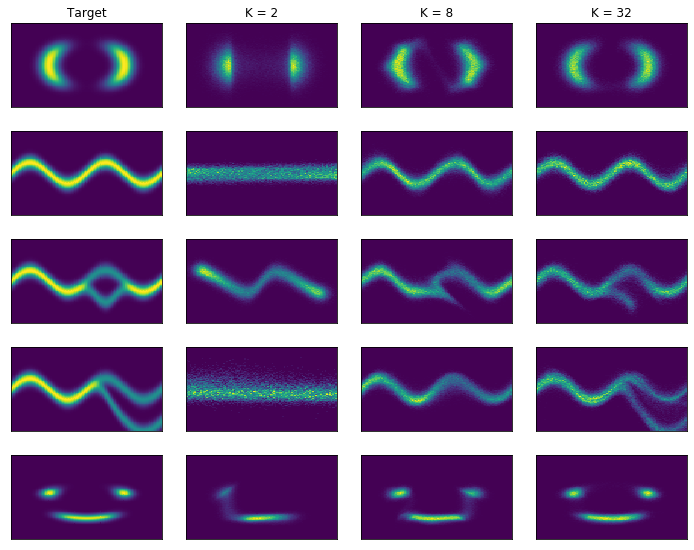

In [18]:
# expressivity plot of the Planar flow
#fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(10, 8))
fig = plt.figure(figsize=(10, 8))
nrows=5
ncols=4
axes = [ fig.add_subplot(nrows, ncols, r * ncols + c + 1) for r in range(0, nrows) for c in range(0, ncols) ]

for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])

grid_size = 100
grid_length = 4.0
grid_shape = ([-grid_length, grid_length], [-grid_length, grid_length])

space_mesh = torch.linspace(-grid_length, grid_length, grid_size)
xx, yy = torch.meshgrid(space_mesh, space_mesh)
z = torch.cat([xx.unsqueeze(2), yy.unsqueeze(2)], 2)
axes[0*ncols + 0].set_title('Target'.format(K))
for k in range(5):
    log_prob = priors[k].log_prob(z)
    prob = torch.exp(log_prob)
    axes[k*ncols + 0].pcolormesh(xx, yy, prob)

for l in range(len(K_arr)):
    K = K_arr[l]
    axes[0*ncols + l+1].set_title('K = {}'.format(K))
    for k in range(5):
        z_np, _ = np.load("K={}-k={}.npy".format(K,k), allow_pickle=True)
        axes[k*ncols + l+1].hist2d(z_np[:, :, 0].flatten(), z_np[:, :, 1].flatten(), (grid_size, grid_size), grid_shape)


fig.tight_layout(pad=2.0)


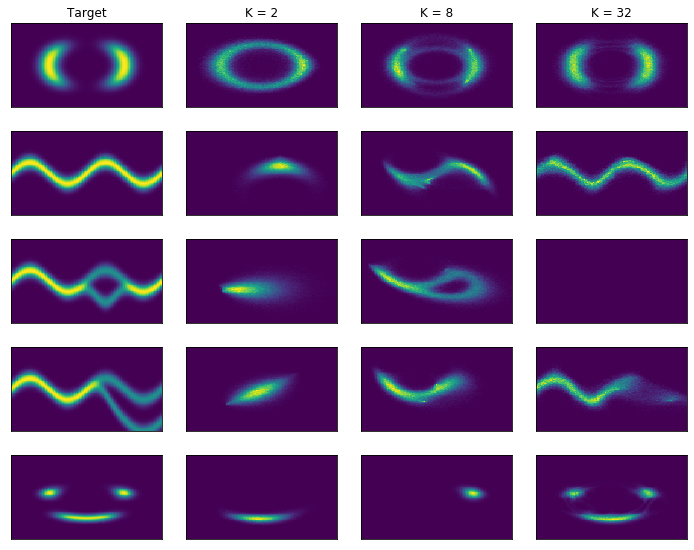

In [19]:
# expressivity plot of the Planar flow
#fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(10, 8))
fig = plt.figure(figsize=(10, 8))
nrows=5
ncols=4
axes = [ fig.add_subplot(nrows, ncols, r * ncols + c + 1) for r in range(0, nrows) for c in range(0, ncols) ]

for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])

grid_size = 100
grid_length = 4.0
grid_shape = ([-grid_length, grid_length], [-grid_length, grid_length])

space_mesh = torch.linspace(-grid_length, grid_length, grid_size)
xx, yy = torch.meshgrid(space_mesh, space_mesh)
z = torch.cat([xx.unsqueeze(2), yy.unsqueeze(2)], 2)
axes[0*ncols + 0].set_title('Target'.format(K))
for k in range(5):
    log_prob = priors[k].log_prob(z)
    prob = torch.exp(log_prob)
    axes[k*ncols + 0].pcolormesh(xx, yy, prob)

for l in range(len(K_arr)):
    K = K_arr[l]
    axes[0*ncols + l+1].set_title('K = {}'.format(K))
    for k in range(5):
        z_np, _ = np.load("rad_K={}-k={}.npy".format(K,k), allow_pickle=True)
        axes[k*ncols + l+1].hist2d(z_np[:, :, 0].flatten(), z_np[:, :, 1].flatten(), (grid_size, grid_size), grid_shape)


fig.tight_layout(pad=2.0)

In [ ]:
# comparison of Planar, Radial, GLOW, CNF on given prior distribution

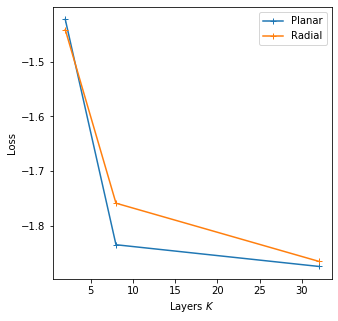

In [3]:
loss_plan = []
loss_rad = []
k = 0 # pick the TwoModes distribution

for K in K_arr:
    _, loss = np.load("K={}-k={}.npy".format(K,k), allow_pickle=True)
    loss_plan.append(loss)
    _, loss = np.load("rad_K={}-k={}.npy".format(K,k), allow_pickle=True,)
    loss_rad.append(loss)

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
#fig.tight_layout(pad=3.0)
axes.plot(K_arr, loss_plan, marker='+', label='Planar')
axes.plot(K_arr, loss_rad, marker='+', label='Radial')
axes.set_xlabel('Layers $K$')
axes.set_ylabel('Loss')
axes.legend()